
 <table align="left">
   <td>
     <a target="_blank" href="https://colab.research.google.com/github/swghosh/UG-Courses/blob/master/CSE3810/Assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
   </td>
   <td>
     <a target="_blank" href="https://github.com/swghosh/UG-Courses/blob/master/CSE3810/Assignment.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
   </td>
   <td>
     <a href="https://raw.githubusercontent.com/swghosh/UG-Courses/master/CSE3810/Assignment.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
   </td>
 </table>

# [Artificial Neural Networks - Assignment](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxhcnRpZmljaWFsbmV1cmFsbmV0d29ya3Nhbm58Z3g6MzZmMzBjY2ZmN2EyMmMyYQ)
Attempt any 4 out of the total 6 questions.

Course: https://sites.google.com/site/artificialneuralnetworksann/lecture-notes


## Q1.
a. Create the Multi-layer Perceptron Neural Network / Back-propagation network from scratch in Python using the weight and bias updation for solving the classification Problem. Also check the linear Separability for AND and XOR problem using the created Multi-layer Perceptron Neural Network algorithm/ Back propagation network.

- **Note:-** Carry out leave-one-out cross-validation (LOOCV) and K-Fold Cross Validationon a simple classification problem. Discuss the best approach amongst the same.

b. Try to Modify the weight and bias updation formula by changing or removing the learning rate used in the Multi-layer Perceptron Neural Network / Back-propagation network to check the impact on the overall performance of the network

<hr>

We import `numpy` for mathematical calculations especially operations like matrix multiplications. It offers an API that is faster than use of regular Python lists and `np.ndarray` is the defacto choice of data structure for any sort of numerical computing tasks.

The `@typechecked` decorator from the `typeguard` package performs runtime checks that guarantees the data type in given scope. It is based on type hinting proposed by [PEP484](https://www.python.org/dev/peps/pep-0484/).

In [1]:
import numpy as np
from typeguard import typechecked
from typing import Callable, List

We set random seed for deterministic results.

In [2]:
np.random.seed(7)

We define common activation functions and their corresponding first order derivative functions (to be used for calculating gradients) for use with neural networks.

- Sigmoid, $ f(x) = \frac {1}{{1 + e^{-x}}} $
- ReLU, $ f(x) = max(0, x) $
- Identity, $ f(x) = x $

In [3]:
@typechecked
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

@typechecked
def sigmoid_grad(x: np.ndarray) -> np.ndarray:
    return sigmoid(x) * (1 - sigmoid(x))

In [4]:
@typechecked
def relu(x: np.ndarray) -> np.ndarray:
    return x * (x > 0).astype(x.dtype)

@typechecked
def relu_grad(x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(x.dtype)

In [5]:
@typechecked
def identity(x: np.ndarray) -> np.ndarray:
    return x

@typechecked
def identity_grad(x: np.ndarray) -> np.ndarray:
    return np.ones_like(x)

We define a log-likelihood based cross-entropy loss for multi-class as well as binary classification problems. (The loss is similar to the one used in case of Logistic Regression)

- $ J(y, hx)  = \frac{-1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} (y_k(i) . log(hx_k) + (1 - y_k(i)).log(1 - hx_k))$

$ y $ is the actual target for given samples and $ hx $ is activation of last layer calculated from neural net. $ m $ is the total number of samples in dataset, $ k $ is the number of classes in case of multi-class classification. In case of binary classification, $ k = 1 $ although number of classes is 2.

To every logarithmic calculation we add a small epsilon value for numerical stability to avoid the case of $ log(0) = $ undefined, which could produce `NaN` values.

In [6]:
# avoid NaN(s)
epsilon = 1e-12

@typechecked
def crossentropy(y: np.ndarray, logits: np.ndarray) -> np.float64:
    assert y.shape == logits.shape, "Both y and logits must have exact same dimensions"
    m = y.shape[0]
    
    y_dash = 1 - y
    logits_dash = 1 - logits
    
    log_hx = np.log(logits + epsilon)
    log_hx_dash = np.log(logits_dash + epsilon)
    
    sample_wise_loss = np.sum((y * log_hx) + (y_dash * log_hx_dash), axis=-1)
    loss = (-1. / m) * np.sum(sample_wise_loss)
    
    return loss 

Test the crossentropy function of sample values.

In [7]:
y = np.array([[1, 0, 1],
              [0, 1, 0],
              [0, 0, 1],
              [1, 0, 0]])
logits =  np.array([[0.7, 0.1, 0.2],
                    [0.6, 0.4, 0.0],
                    [0.3, 0.1, 0.6],
                    [0.2, 0.2, 0.6]])
crossentropy(y, logits)

1.906447028684372

In [8]:
y = np.array([[1],
              [0],
              [0],
              [1]])
logits =  np.array([[0.7],
                    [0.6],
                    [0.3],
                    [0.2]])
crossentropy(y, logits)

0.8097696330438409

In case of neural networks, it is important initialize weights randomly in order to ensure that the models can train properly using backpropagation of gradients.

We initialize the weights in a range of:
- $ (- e_{init}, + e_{init}) $

Where, $ e_{init} = \frac {\sqrt 6} {\sqrt {i + o}} $ such that $ i = $ number of nodes in input layer and $ o = $ number of nodes in output layer.

In [9]:
@typechecked
def initialize_weights(shape: tuple) -> np.ndarray:
    out_dim, in_dim = shape
    e_init = np.sqrt(6) / np.sqrt(out_dim + in_dim)
    
    weights = np.random.uniform(-e_init, e_init, size=shape)
    return weights

We test the function by generating sample weights.

In [10]:
shape = (9, 3)
initialize_weights(shape)

array([[-5.99190563e-01,  3.95864952e-01, -8.71025002e-02],
       [ 3.16027485e-01,  6.75979251e-01,  5.44413820e-02],
       [ 1.58457490e-03, -6.05211091e-01, -3.27476735e-01],
       [-1.66168926e-04,  2.53469491e-01,  4.29551864e-01],
       [-1.68374664e-01, -6.13858705e-01, -2.99607367e-01],
       [ 5.79252722e-01, -4.05334320e-01, -6.77069425e-02],
       [ 6.09817401e-01, -6.71893956e-01,  1.42197643e-01],
       [ 6.36579244e-01, -3.81409326e-01,  6.85751014e-02],
       [ 5.78594897e-01, -5.18776745e-01,  3.31103891e-02]])

A neural network is composed by stacking multiple layer of neurons. A neuron or a node is an essential building block of any neural net which takes in multiple features and returns a weighted sum. Neural nets are built such that the gradient of each of the nodes can be computed efficiently when we perform back propagation.

In [11]:
class Layer:
    @typechecked
    def __init__(self, input_dim: int, output_dim: int, 
                 activation: Callable = identity, 
                 activation_grad: Callable = identity_grad):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.wb = initialize_weights((output_dim, input_dim + 1))
        self.activation = activation
        self.activation_grad = activation_grad
    
    @typechecked
    def get_size(self) -> tuple:
        return self.input_dim, self.output_dim
    
    def forward(self, inputs):
        n_samples, n_features = inputs.shape

        assert n_features == self.input_dim, "Inputs must be a"\
            f" n x {self.input_dim} matrix"
        
        ones = np.ones((n_samples, 1))
        
        inputs = np.hstack([ones, inputs])

        outputs = self.activation(inputs @ self.wb.T)
        return outputs
    
    def backward(self, inputs, targets, precomputed=True):
        n_samples, n_features = inputs.shape

        assert n_features == self.input_dim, "Inputs must be a"\
            f" n x {self.input_dim} matrix"
        assert n_samples == targets.shape[0], "Targets must contain"\
            f" equal number of samples as inputs"
        
        if precomputed:
            delta = targets
        else:
            delta = self.forward(inputs) - targets
        
        ones = np.ones((n_samples, 1))
        inputs = np.hstack([ones, inputs])
        grad_outputs = self.activation_grad(inputs @ self.wb.T)
        
        if precomputed:
            delta = delta[:, 1:]
        
        return delta * grad_outputs

We generate a bunch of random samples with 5 features each and forward pass it by constructing single layer.

In [12]:
n_samples = 10
n_features = 5
n_neurons = 3

X = np.random.normal(size=(n_samples, n_features))

In [13]:
layer = Layer(n_features, n_neurons, identity, identity_grad)
out = layer.forward(X)
assert out.shape == (n_samples, n_neurons)
out

array([[-1.57518191,  0.24452772,  0.05870976],
       [-0.78413132, -0.12678921,  0.33040293],
       [-0.88559746, -0.04927112,  0.83574895],
       [-0.96353498,  2.83573575,  3.40184519],
       [ 0.44232208,  0.17134944, -1.34529329],
       [ 1.3403991 , -0.31037801, -1.28504574],
       [ 0.75902158,  1.42873261,  1.03802311],
       [-0.26810492,  0.63724628,  0.32585779],
       [-1.48223789,  1.63982099,  1.73728051],
       [-1.40193358,  1.35851674,  1.99508395]])

We repeat the forward pass step on another set of random values.

In [14]:
n_samples = 4
input_dim = 5
output_dim = 3

X = np.random.normal(size=(n_samples, input_dim))
y = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [1., 0., 0.],
              [0., 0., 1.]])

In [15]:
layer = Layer(input_dim, output_dim, sigmoid, sigmoid_grad)
layer.forward(X)

array([[0.84051488, 0.20926822, 0.51411997],
       [0.48249458, 0.24151765, 0.63672302],
       [0.63390105, 0.22182176, 0.73553317],
       [0.49802791, 0.42744909, 0.42547885]])

We try to backpropagate the gradients for the single layer that we constructed and calculate delta terms.

In [16]:
layer.backward(X, y, precomputed=False)

array([[-0.02137892,  0.03462867,  0.12842749],
       [ 0.12047579, -0.13894401,  0.14727837],
       [-0.08496077,  0.03829018,  0.14307895],
       [ 0.12450504,  0.10461234, -0.14043974]])

We create 2 layers and use 4 random samples to perform back propagation on each layer and calculate the delta terms for each layer interactively to check our implementation.

In [17]:
n_samples = 4
input_dim_layer1 = 10
output_dim_layer1 = input_dim_layer2 = 5
output_dim_layer2 = 3

X = np.random.normal(size=(n_samples, input_dim_layer1))
y = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [1., 0., 0.],
              [0., 0., 1.]])
assert y.shape[1] == output_dim_layer2

In [18]:
mlp_layers = [
    Layer(input_dim_layer1, output_dim_layer1, identity, identity_grad),
    Layer(input_dim_layer2, output_dim_layer2, identity, identity_grad)
]

In [19]:
h = mlp_layers[0].forward(X)
t = mlp_layers[1].forward(h)

In [20]:
targets = y
grads2 = mlp_layers[1].backward(h, targets, precomputed=False)
targets = grads2 @ mlp_layers[1].wb
grads1 = mlp_layers[0].backward(X, targets)
targets = grads1 @ mlp_layers[0].wb

The gradients for each layer is displayed.

In [21]:
grads1

array([[-0.02001019,  0.44617628, -0.13238643, -0.17110108, -0.12035985],
       [ 0.37120101,  0.36248596,  0.00882967,  0.98162553, -1.04700279],
       [-0.52976237,  0.95978732,  0.75259816, -0.18609447, -0.7486013 ],
       [-0.15665489,  0.33865018,  0.79715207,  0.72367494, -1.08087211]])

In [22]:
grads2

array([[-0.93899412, -0.114936  , -0.65514189],
       [ 0.43265849, -0.78981053, -0.70710089],
       [-1.78594548, -1.18147702, -0.76818343],
       [ 0.22952104, -1.2699273 , -0.09863178]])

A NN class is defined which will model a high-level API for a neural network with multiple layers. It can be referred to as a multi layer perceptron as the network will be used primariliy for classification tasks. The class includes the ability to backpropagate, calculate gradients of each nodes and update the neuron weights based on delta learning rule.

The train method is used to train the neural network on a set of given inputs and outputs for a classification problem.

In [23]:
class NN:
    @typechecked
    def __init__(self, layers: List[Layer], alpha: float):
        assert len(layers) > 0, "Number of layers should be atleast one"
        NN.check_shapes(layers)
        
        self.layers = layers
        self.alpha = alpha
    
    @staticmethod
    def check_shapes(layers: List[Layer]):
        prev_layer = layers[0]
        for layer in layers[1:]:
            _, prev_output = prev_layer.get_size()
            this_input, _ = layer.get_size()
            
            assert prev_output == this_input, "Layer input size must exactly"\
                " match output shape of the preceeding layer"
            
            prev_layer = layer
    
    @typechecked
    def forward(self, inputs: np.ndarray) -> List[np.ndarray]:
        out = inputs
        acts = [inputs]
        for layer in self.layers:
            out = layer.forward(out)
            acts.append(out)
        return acts
    
    @typechecked
    def __call__(self, inputs: np.ndarray) -> np.ndarray:
        return self.forward(inputs)[-1]
    
    @typechecked
    def backward(self, inputs: np.ndarray, targets: np.ndarray) -> (List[np.ndarray], List[np.ndarray]):
        acts = self.forward(inputs)
        last = True

        grads = []
        for i in range(len(self.layers) - 1, -1, -1):
            grad = self.layers[i].backward(acts[i], targets, precomputed=not last)
            targets = grad @ self.layers[i].wb
            grads.append(grad)

            if last:
                last = not last
        grads.reverse()
        return acts, grads
    
    @typechecked
    def __str__(self) -> str:
        s = ''
        for i, layer in enumerate(self.layers):
            s += f"Layer {i}: {layer.get_size()}\n"
        return s
    
    @typechecked
    def update_weights(self, deltas: List[np.ndarray]):
        for layer, delta in zip(self.layers, deltas):
            layer.wb = layer.wb - self.alpha * delta
    
    @typechecked
    def calculate_deltas(self, X: np.ndarray, y: np.ndarray) -> List[np.ndarray]:
        n_samples = X.shape[0]
        acts, grads = self.backward(X, y)
        deltas = []
        for act, grad in zip(acts, grads):
            ones = np.ones((n_samples, 1))
            act = np.hstack([ones, act])
            
            delta = (act.T @ grad).T
            delta /= n_samples
            deltas.append(delta)
        return deltas
    
    @typechecked
    def train(self, X: np.ndarray, y: np.ndarray, 
              epochs: int, verbose: bool = True):
        for e in range(1, epochs + 1):
            deltas = self.calculate_deltas(X, y)
            self.update_weights(deltas)
            
            if verbose:
                logits = self(X)
                print(f"Epoch {e}: Cross-entropy loss: {crossentropy(y, logits)}")

We generate a few more random samples with 20 features each and train the neural network

In [24]:
n_samples = 100
input_dim_layer1 = 20
output_dim_layer1 = input_dim_layer2 = 10
output_dim_layer2 = input_dim_layer3 = 5
output_dim_layer3 = input_dim_layer4 = 4
num_classes = output_dim_layer4 = 3

X = np.random.normal(size=(n_samples, input_dim_layer1))
y = np.random.randint(0, num_classes, size=(n_samples))

eye = np.eye(num_classes)
y = eye[y] # encode as one-hot

X.shape, y.shape

((100, 20), (100, 3))

A five layer neural network is used.
- Input Layer with size: 20
- Hidden Layer with size: 10
- Hidden Layer with size: 5
- Hidden Layer with size: 4
- Output Layer with size: 3

Increasing the number of hidden layers in any neural network is known to increase the learning capacity of the model.

In [25]:
net = NN([
    Layer(input_dim_layer1, output_dim_layer1, sigmoid, sigmoid_grad),
    Layer(input_dim_layer2, output_dim_layer2, sigmoid, sigmoid_grad),
    Layer(input_dim_layer3, output_dim_layer3, sigmoid, sigmoid_grad),
    Layer(input_dim_layer4, output_dim_layer4, sigmoid, sigmoid_grad)
], alpha=0.01)
print(net)

Layer 0: (20, 10)
Layer 1: (10, 5)
Layer 2: (5, 4)
Layer 3: (4, 3)



Gradients and forward pass activations are computed for this MLP.

In [26]:
acts, grads = net.backward(X, y)
deltas = net.calculate_deltas(X, y)

In [27]:
net.train(X, y, 200)

Epoch 1: Cross-entropy loss: 2.142877610092765
Epoch 2: Cross-entropy loss: 2.1421743006309395
Epoch 3: Cross-entropy loss: 2.1414730344868302
Epoch 4: Cross-entropy loss: 2.14077380668996
Epoch 5: Cross-entropy loss: 2.1400766122727437
Epoch 6: Cross-entropy loss: 2.139381446270565
Epoch 7: Cross-entropy loss: 2.1386883037218527
Epoch 8: Cross-entropy loss: 2.137997179668159
Epoch 9: Cross-entropy loss: 2.1373080691542286
Epoch 10: Cross-entropy loss: 2.1366209672280814
Epoch 11: Cross-entropy loss: 2.135935868941079
Epoch 12: Cross-entropy loss: 2.135252769348004
Epoch 13: Cross-entropy loss: 2.134571663507128
Epoch 14: Cross-entropy loss: 2.133892546480291
Epoch 15: Cross-entropy loss: 2.1332154133329633
Epoch 16: Cross-entropy loss: 2.1325402591343248
Epoch 17: Cross-entropy loss: 2.1318670789573333
Epoch 18: Cross-entropy loss: 2.131195867878792
Epoch 19: Cross-entropy loss: 2.1305266209794222
Epoch 20: Cross-entropy loss: 2.1298593333439317
Epoch 21: Cross-entropy loss: 2.1291940

The learning rate is considered a very important hyper parameter in case of neural network learning. It measures the rate at which each node of the network is able to learn for any given update step.

By adjusting learning rate (alpha) value we can often achieve better models. The optimal value of alpha is experimentally set and is highly dependent on data inputs. 

In [28]:
net = NN([
    Layer(input_dim_layer1, output_dim_layer1, sigmoid, sigmoid_grad),
    Layer(input_dim_layer2, output_dim_layer2, sigmoid, sigmoid_grad),
    Layer(input_dim_layer3, output_dim_layer3, sigmoid, sigmoid_grad),
    Layer(input_dim_layer4, output_dim_layer4, sigmoid, sigmoid_grad)
], alpha=0.1)
print(net)
net.train(X, y, 1000)

Layer 0: (20, 10)
Layer 1: (10, 5)
Layer 2: (5, 4)
Layer 3: (4, 3)

Epoch 1: Cross-entropy loss: 1.9608873684259989
Epoch 2: Cross-entropy loss: 1.959230426859254
Epoch 3: Cross-entropy loss: 1.9576252801418517
Epoch 4: Cross-entropy loss: 1.956070198344021
Epoch 5: Cross-entropy loss: 1.954563511248733
Epoch 6: Cross-entropy loss: 1.9531036063918024
Epoch 7: Cross-entropy loss: 1.9516889271476177
Epoch 8: Cross-entropy loss: 1.9503179708616598
Epoch 9: Cross-entropy loss: 1.948989287030641
Epoch 10: Cross-entropy loss: 1.9477014755308404
Epoch 11: Cross-entropy loss: 1.9464531848949385
Epoch 12: Cross-entropy loss: 1.9452431106374624
Epoch 13: Cross-entropy loss: 1.9440699936287573
Epoch 14: Cross-entropy loss: 1.9429326185172053
Epoch 15: Cross-entropy loss: 1.9418298121993112
Epoch 16: Cross-entropy loss: 1.9407604423371174
Epoch 17: Cross-entropy loss: 1.9397234159222922
Epoch 18: Cross-entropy loss: 1.9387176778861928
Epoch 19: Cross-entropy loss: 1.937742209755057
Epoch 20: Cross

**AND Problem**

AND problem is a classic problem in the field of ANN (also, important from the perspective of digital electronics) that is used to test linear seperation ability of a neural network. AND function has the following truth table:

| x1 | x2 | y |
| --- | --- | --- | 
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

We train a single layer neural network on binary classification task to help it learn the AND function.

In [29]:
X = np.array([[0., 0.], 
              [0., 1.], 
              [1., 0.], 
              [1., 1.]])
y = np.array([[0.], 
              [0.], 
              [0.], 
              [1.]])

and_net = NN([
    Layer(2, 1, sigmoid, sigmoid_grad)
], alpha=0.9)

and_net.train(X, y, 1000)

Epoch 1: Cross-entropy loss: 0.8484504067845117
Epoch 2: Cross-entropy loss: 0.8336904717124938
Epoch 3: Cross-entropy loss: 0.8195747229956256
Epoch 4: Cross-entropy loss: 0.806071005272858
Epoch 5: Cross-entropy loss: 0.7931497690362819
Epoch 6: Cross-entropy loss: 0.7807834870355709
Epoch 7: Cross-entropy loss: 0.768946174755105
Epoch 8: Cross-entropy loss: 0.7576130119710539
Epoch 9: Cross-entropy loss: 0.7467600582507132
Epoch 10: Cross-entropy loss: 0.7363640525414765
Epoch 11: Cross-entropy loss: 0.7264022853834802
Epoch 12: Cross-entropy loss: 0.7168525315354917
Epoch 13: Cross-entropy loss: 0.7076930307532292
Epoch 14: Cross-entropy loss: 0.6989025049593528
Epoch 15: Cross-entropy loss: 0.6904602009662647
Epoch 16: Cross-entropy loss: 0.6823459491358692
Epoch 17: Cross-entropy loss: 0.6745402297707891
Epoch 18: Cross-entropy loss: 0.6670242405249227
Epoch 19: Cross-entropy loss: 0.659779959606904
Epoch 20: Cross-entropy loss: 0.6527902009542095
Epoch 21: Cross-entropy loss: 0.

In [30]:
and_net(X)

array([[0.00392238],
       [0.12817127],
       [0.12818149],
       [0.8458958 ]])

A threshold value of 0.7 appears to be a good value of threshold for this case.

In [31]:
(and_net(X) > 0.7).astype(np.float32)

array([[0.],
       [0.],
       [0.],
       [1.]], dtype=float32)

**XOr Problem**

XOr problem is a classic problem in the field of ANN (also, important from the perspective of digital electronics) that is used to test non-linear seperation ability of a neural network. XOr function has the following truth table:

| x1 | x2 | y |
| --- | --- | --- | 
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

We train the neural network on binary classification task to help it learn the XOr function.

In [32]:
X = np.array([[0., 0.], 
              [0., 1.], 
              [1., 0.], 
              [1., 1.]])
y = np.array([[0.], 
              [1.], 
              [1.], 
              [0.]])

xor_net = NN([
    Layer(2, 10, sigmoid, sigmoid_grad),
    Layer(10, 1, sigmoid, sigmoid_grad)
], alpha=1.0)

xor_net.train(X, y, 2000)

Epoch 1: Cross-entropy loss: 0.7675102928072906
Epoch 2: Cross-entropy loss: 0.7411166288504509
Epoch 3: Cross-entropy loss: 0.722971816078948
Epoch 4: Cross-entropy loss: 0.7112225891841927
Epoch 5: Cross-entropy loss: 0.7039476428114885
Epoch 6: Cross-entropy loss: 0.6995783621755961
Epoch 7: Cross-entropy loss: 0.6970042263692224
Epoch 8: Cross-entropy loss: 0.6955046962948086
Epoch 9: Cross-entropy loss: 0.6946362332252014
Epoch 10: Cross-entropy loss: 0.6941341906452554
Epoch 11: Cross-entropy loss: 0.6938435090094097
Epoch 12: Cross-entropy loss: 0.6936742868848711
Epoch 13: Cross-entropy loss: 0.6935747137633346
Epoch 14: Cross-entropy loss: 0.6935150334687072
Epoch 15: Cross-entropy loss: 0.6934781895041082
Epoch 16: Cross-entropy loss: 0.6934544156983189
Epoch 17: Cross-entropy loss: 0.6934381236235975
Epoch 18: Cross-entropy loss: 0.6934261165670573
Epoch 19: Cross-entropy loss: 0.6934165662919676
Epoch 20: Cross-entropy loss: 0.6934084273236628
Epoch 21: Cross-entropy loss: 

In [33]:
xor_net(X)

array([[0.09338322],
       [0.88614887],
       [0.87959105],
       [0.13931045]])

A threshold value of 0.7 appears to be a good value of threshold for this case.

In [34]:
(xor_net(X) > 0.7).astype(np.float32)

array([[0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

**[Pima Indian Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)**

Pima Indian Diabetes Dataset is a multi-class classification dataset with 8 feature variables and 1 target variable.

In [35]:
dataset = np.loadtxt(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', 
    delimiter=',')
dataset.shape

(768, 9)

The features and targets are separated as $ X $, $ y $.

In [36]:
X = dataset[:, :-1]
y = dataset[:, -1:]

In [37]:
from sklearn.model_selection import KFold

K-Fold cross validation is a technique used to evaluate a machine learning problem by splitting the dataset into k equal halves using hold out test set method. The classifier is trained on (k-1) folds and evaluated on the remaining hold out set. The evaluation metrics are aggregated over all the k-folds of test sets.

In [38]:
def k_fold_cv(n_splits, X, y):
    kfold = KFold(n_splits, random_state=7, shuffle=True)
    cv_loss = []
    for train_indices, test_indices in kfold.split(X, y):
        classifier = NN([
            Layer(X.shape[-1], 10, sigmoid, sigmoid_grad),
            Layer(10, 5, sigmoid, sigmoid_grad),
            Layer(5, 1, sigmoid, sigmoid_grad)
        ], alpha=0.1)

        classifier.train(X[train_indices], y[train_indices], 1000, False)

        y_predict = classifier(X[test_indices])
        test_loss = crossentropy(y[test_indices], y_predict)
        print(f"Cross entropy loss (test set): {test_loss}")

        cv_loss.append(test_loss)

    cv_loss = np.array(cv_loss)
    print("Loss (k-Folds): %0.03f±%0.03f" % (cv_loss.mean(), cv_loss.std()))
    
k_fold_cv(5, X, y)

Cross entropy loss (test set): 0.6591461696847586
Cross entropy loss (test set): 0.6170053152639993
Cross entropy loss (test set): 0.6309309061669961
Cross entropy loss (test set): 0.6849316465210163
Cross entropy loss (test set): 0.6196645354035495
Loss (k-Folds): 0.642±0.026


A Leave-one-out cross validation technique is similar to k-fold cross validation just that the number of splits (k) is exactly equal to the number of samples in dataset.

For computational time constraints, we subset the dataset for 20 samples and then run the LOOCV evaluation.

In [39]:
def loocv(X, y):
    n_splits = X.shape[0]
    k_fold_cv(n_splits, X, y)
    
loocv(X[:20], y[:20]) # using a subset of 20 samples only

Cross entropy loss (test set): 1.1008820925379583
Cross entropy loss (test set): 0.6261570573644808
Cross entropy loss (test set): 0.6935991398438032
Cross entropy loss (test set): 0.9155073354496069
Cross entropy loss (test set): 0.503106801592252
Cross entropy loss (test set): 0.5465815474721764
Cross entropy loss (test set): 1.2311513928237283
Cross entropy loss (test set): 0.48757629005448483
Cross entropy loss (test set): 0.34091278993362406
Cross entropy loss (test set): 0.45871100132193887
Cross entropy loss (test set): 1.0783825171860322
Cross entropy loss (test set): 0.42163102843241934
Cross entropy loss (test set): 0.3178585818331187
Cross entropy loss (test set): 0.3245647106894865
Cross entropy loss (test set): 0.49971057931953805
Cross entropy loss (test set): 0.9793801010790257
Cross entropy loss (test set): 1.0125862839581394
Cross entropy loss (test set): 1.1766412856275177
Cross entropy loss (test set): 0.4470074863297201
Cross entropy loss (test set): 0.5180712955255

K-Fold cross validation technique is much better than LOOCV technqiue because:
- it is impossible and computationally challenging to train n number of models equal to n number of samples given any large dataset
- K-fold CV in this case aggregates cross-entropy loss over 5 folds and is less time consuming.
- Leaving out just one test element greatly impacts the evaluation as loss reported can sometimes be very high

## Q2.

Implement the problem mentioned below in Python.

**Problem:-**
A network is created when we multiple neurons stack together. Let us take an example of a neural network simulating an XNOR function.

![XNOR Function NN](https://i.imgur.com/91kmPbs.jpg)

You can see that the last neuron takes input from two neurons before it. The activation function for all the neurons is given by:

$ f(x) = \left\{ \begin{array}{ll}
      0 & for & x\leq 0 \\
      1 & for & x\geq 0 \\
\end{array}
\right. $

Suppose X1 is 0 and X2 is 1, what will be the output for the above neural network? <br/>
A) 0 <br/>
B) 1

<hr>

In [40]:
import numpy as np
from typeguard import typechecked
from typing import List, Callable, Union

Feed forward network layer.

In [41]:
class NeuronLayer:
    @typechecked
    def __init__(self, w: np.ndarray, b: np.ndarray, 
                 activation: Union[Callable, None] = None):
        assert w.ndim == 2, "Weights must be 2D matrix"
        assert b.ndim == 1, "Biases must be 1D vector"
        assert w.shape[0] == b.shape[0], "Weights and biases must"\
            " conform to same number of neurons"

        self.weights = w
        self.biases = b

        self.activation = activation
    
    @typechecked
    def get_size(self) -> tuple:
        output_size, input_size = self.weights.shape
        return input_size, output_size

    @typechecked
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        n_samples, n_features = inputs.shape

        assert n_features == self.weights.shape[-1], "Inputs must be a"\
            f" n x {n_features} matrix"
        n_neurons = self.weights.shape[0]

        ones = np.ones((n_samples, 1))
        
        inputs = np.hstack([ones, inputs])
        b = np.expand_dims(self.biases, -1)
        wb = np.hstack([b, self.weights])

        output = inputs @ wb.T
        if self.activation is not None:
            return self.activation(output)
        else:
            return output

    @typechecked
    def __call__(self, inputs: np.ndarray) -> np.ndarray:
        return self.forward(inputs)

Set random seed for determininstic results.

In [42]:
np.random.seed(7)

We generate a bunch of random samples with 5 features each and forward pass it by constructing single layer.

In [43]:
n_samples = 10
n_features = 5
n_neurons = 3

X = np.random.normal(size=(n_samples, n_features))
w = np.random.random(size=(n_neurons, n_features))
b = np.random.random(size=(n_neurons, ))

The layer outputs are checked.

In [44]:
layer1 = NeuronLayer(w, b)
layer1_output = layer1(X)
assert layer1.get_size() == (n_features, n_neurons)

We define a NeuralNet class that allows calculating of forward pass for a series of layers.

In [45]:
class NeuralNet:
    @typechecked
    def __init__(self, layers: List[NeuronLayer]):
        assert len(layers) > 0, "Number of layers should be atleast one"
        NeuralNet.check_shapes(layers)
        self.layers = layers
            
    @staticmethod
    def check_shapes(layers: List[Layer]):
        prev_layer = layers[0]
        for layer in layers[1:]:
            _, prev_output = prev_layer.get_size()
            this_input, _ = layer.get_size()
            
            assert prev_output == this_input, "Layer input size must exactly"\
                " match output shape of the preceeding layer"
            
            prev_layer = layer
    
    @typechecked
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs
    
    @typechecked
    def __call__(self, inputs: np.ndarray) -> np.ndarray:
        return self.forward(inputs)

We generate another bunch of samples and random weights and biases for creating another 3 layer network.

In [46]:
n_samples = 10
n_features = 5
n_neurons_layer1 = 3
n_neurons_layer2 = 5
n_neurons_layer3 = 1

X = np.random.normal(size=(n_samples, n_features))

w1 = np.random.random(size=(n_neurons_layer1, n_features))
b1 = np.random.random(size=(n_neurons_layer1, ))

w2 = np.random.random(size=(n_neurons_layer2, n_neurons_layer1))
b2 = np.random.random(size=(n_neurons_layer2, ))

w3 = np.random.random(size=(n_neurons_layer3, n_neurons_layer2))
b3 = np.random.random(size=(n_neurons_layer3, ))

Some activation functions are defined.

In [47]:
identity = lambda x: x
relu = lambda x: np.maximum(x, 0)

In [48]:
layer1 = NeuronLayer(w1, b1, relu)
layer2 = NeuronLayer(w2, b2, relu)
layer3 = NeuronLayer(w3, b3, identity)

We compute the output of last layer by chaining all the layer functions.

In [49]:
y = layer3(layer2(layer1(X)))
y

array([[1.00138383],
       [5.68665987],
       [5.45742112],
       [4.30953155],
       [5.96850311],
       [5.2887552 ],
       [6.18013203],
       [2.46759842],
       [8.05767774],
       [5.08341227]])

The same is tested against outputs produced from the NeuralNet class.

In [50]:
net = NeuralNet([layer1, layer2, layer3])
assert all(net(X) == y)
net(X)

array([[1.00138383],
       [5.68665987],
       [5.45742112],
       [4.30953155],
       [5.96850311],
       [5.2887552 ],
       [6.18013203],
       [2.46759842],
       [8.05767774],
       [5.08341227]])

Step activation function is defined as:
$ f(x) = \left\{ \begin{array}{ll}
      0 & for & x\leq 0 \\
      1 & for & x\geq 0 \\
\end{array}
\right. $

In [51]:
step = lambda x: (x > 0).astype(x.dtype)

We compute the output for given values of inputs, weights and biases in question.

In [52]:
x1 = 0
x2 = 1

w1 = np.array([[-1, -1], [1, 1]])
b1 = np.array([0.5, -1.5])

w2 = np.array([[1, 1]])
b2 = np.array([-0.5])

In [53]:
hidden_layer = NeuronLayer(w1, b1, step)
output_layer = NeuronLayer(w2, b2, step)
xnor_net = NeuralNet([hidden_layer, output_layer])

In [54]:
X = np.array([[x1, x2]])

In [55]:
h = hidden_layer(X)
h

array([[0., 0.]])

In [56]:
t = output_layer(h)
t

array([[0.]])

In [57]:
y = xnor_net(X)
assert all(y == t)
y

array([[0.]])

For the given XNOR problem, when X1 = 0 and X2 = 1 the output of the network comes to 0.

**XNOR Truth Table**

The XNOR function gives high output (1) results if both of the inputs to the function are the same.

| $ x1 $ | $ x2 $ | $ x1 $ &#9737; $ x2 $ |
| --- | --- | --- |
| 0 | 0 | **1** |
| 0 | 1 | **0** |
| 1 | 0 | **0** |
| 1 | 1 | **1** |

In [58]:
X = np.array([[0, 0], 
              [0, 1], 
              [1, 0], 
              [1, 1]])
xnor_net(X)

array([[1.],
       [0.],
       [0.],
       [1.]])

## Q3.
In training a neural network, you notice that the loss does not decrease in the few starting epochs.

![learning curve](https://i.imgur.com/rO34ZXB.png)

The reasons for this could be:
1. The learning is rate is low
2. Regularization parameter is high
3. Stuck at local minima

What according to you are the probable reasons? Justify your answer regarding the same.
<hr>

There could be a wide range of probable reasons as to why a particular neural network could be stuck with approximately a same error rate while on a training loop. A deeper dive into the model architecture as well as the dataset on which it is being trained on could sometimes provide for better insights in such a case. One of the approaches could be to visualise the cost function in terms of weights and biases to obtain meanigngul analysis. The cost function of a neural network, often expressed as $ J(\theta) $ can be visualised with the help of contour plots or three-dimensional surfaces. In case of data with large number of dimensions (features), a suitable data reduction step should be applied.

The problem for loss not decreasing much in the starting few epochs could be expressed in terms as follows:
- **low learning rate** - The learning rate or the alpha hyperparameter is the value that deterimines the rate of learning at each step (after gradient calculation) for a given neural network training. Lower learning rates are usually good as they'll require more time to train but would perform a more strategic search of the required minima point. In case of a very high learning rate the gradients would get multiplied by very large values during weight updation and may altogether diminish the learning capability of the model. The right value for alpha is generally determined using hyper-parameter tuning. When, the learning rate is low it can be certain that the neural network takes longer to find the right minima point and thus, loss reduction at initial epochs could be very low.
- **high regularization parameter** - Regularization is the process of introducing generalization in case of neural networks so as to prevent overfitting problem in general. The bias vs variance trade-off is a classic machine learning paradigm that helps develop meaningful insights about over-fitting and under-fitting of models. When the regularization is too high, the weights and biases of the network are passed through a penalty so as to make sure that each of the large weights do not contribute over capability and prevent their dominance. It some datasets, this is useful and the same regularization value must not be good enough for every dataset which makes the neural net resist large gradient updates. The regularization term is defined in the loss function itself such that while training when loss reduction is in process, there tends to be restraining of weights in place. In case of the given neural net, where starting epochs fail to effectively reduce the loss there is a possibility of high regularization.
- **local minima** - Most backpropagated networks learn with the help a gradient descent algorithm or with its other variants. Gradient descent (and its variants) form a class of unconstrained optimization algorithm which look for minima of a given function. All these algorithms have no apriori about the data itself and thus cannot distinguish whether a point of minima is a local minima or a global minima. It is practically possible for such a model to be stuck at local minima for quite some iterations unless there is a gradient good enough both in terms of magnitude and direction to help it move toward the global optima again.

## Q4.
Build and train a ConvNet in Python using TensorFlow / keras for an image classification problem and explain each and every line in the comment section.  

Also, try to improve the performance of the model by applying various hyper parameter tuning to reduce the overfitting or under fitting problem that might occur.

<hr>

## Q5.
Write code in Python preferably using TensorFlow / keras to perform object detection using CNN. 

<hr>

`tf.keras` is TensorFlow's high-level API for building and training deep learning models. It's used for fast prototyping, state-of-the-art research, and production.

`tf.data` is TensorFlow's high-level API for building data pipelines that are used to efficiently train machine learning and deep learning models even using multi-worker distributed systems.

In [59]:
import tensorflow as tf
from tensorflow.keras import layers, models
from math import ceil
from matplotlib import pyplot as plt
from IPython.display import Image

[**VOC Pascal (2007 / ) 2012 Dataset**](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)

VOC Pascal 2012 dataset is a dataset containing large number of images comprising of 20 objects. We use the dataset to perform class wise segmentation of different objects.

In [60]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xf VOCtrainval_06-Nov-2007.tar

In [61]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

--2020-05-16 13:10:30--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  3.60MB/s    in 8m 52s  

2020-05-16 13:19:24 (3.58 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [62]:
images_path = './VOCdevkit/VOC2012/JPEGImages'
masks_path = './VOCdevkit/VOC2012/SegmentationClass'

The given dataset provides us with training and validation sets each containing the original image and segmentation mask with pixel values as per the class of object which each belongs to.

In [63]:
train_list_path = './VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt'
val_list_path = './VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt'

In [64]:
def read_im_list(path):
    with open(path) as txt_file:
        imlist = txt_file.read()
        imlist = imlist.split('\n')[:-1]
    images_list = [images_path + f"/{i}.jpg" for i in imlist]
    labels_list = [masks_path + f"/{i}.png" for i in imlist]
    return images_list, labels_list

In [65]:
train_images_list, train_labels_list = read_im_list(train_list_path)
val_images_list, val_labels_list = read_im_list(val_list_path)

The dataset follows a definitive color map for pixel wise representation of object class. Each of the 20 object classes and the background class has distinctive color values as shown.

In [66]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

We convert the color map into gray map for faster computation. (also, gray maps can hold 21 distinct classes easily)

In [67]:
colormap = tf.convert_to_tensor(VOC_COLORMAP)
colormap = colormap[None, ...]
gray_colormap = tf.image.rgb_to_grayscale(colormap)
gray_colormap = gray_colormap[0, ..., 0]
colormap = colormap[0]

The image size is set to 160 x 160 and training as well as validation batch size is set to 32.

In [68]:
image_size = (160, 160)
batch_size = 32
num_classes = len(VOC_CLASSES)

We define functions to use with the `tf.data.Dataset` pipeline to get input image and corresponding mask in the required format for training.

In [69]:
@tf.function
def get_image(image_path):
    raw_bytes = tf.io.read_file(image_path)
    rgb_image = tf.image.decode_png(raw_bytes)
    rgb_image = tf.image.resize_with_pad(rgb_image, *image_size)
    rgb_image = tf.cast(rgb_image, tf.float32)
    rgb_image = rgb_image / 255.
    return rgb_image

@tf.function
def get_labels(mask_path):
    raw_bytes = tf.io.read_file(mask_path)
    rgb_image = tf.image.decode_png(raw_bytes)
    gray_image = tf.image.rgb_to_grayscale(rgb_image)
    gray_image = tf.image.resize_with_pad(gray_image, *image_size)
    flat_image = tf.reshape(gray_image, [-1, 1])
    flat_image = tf.cast(flat_image, tf.int32)
    
    labels = tf.math.equal(gray_colormap, flat_image)
    labels = tf.cast(labels, tf.int32)
    labels = tf.argmax(labels, axis=-1)
    labels = tf.reshape(labels, (*image_size, 1))
    return labels

def dataset(impaths, lpaths):
    images_ds = tf.data.Dataset.from_tensor_slices(impaths)
    images_ds = images_ds.map(get_image, tf.data.experimental.AUTOTUNE)

    labels_ds = tf.data.Dataset.from_tensor_slices(lpaths)
    labels_ds = labels_ds.map(get_labels, tf.data.experimental.AUTOTUNE)

    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    return ds

def prepare_dataset(ds):
    ds = ds.cache()
    
    num_samples = tf.data.experimental.cardinality(ds)
    ds = ds.shuffle(num_samples)

    ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

The training and validation data pipelines are constructed.

In [70]:
train_ds = dataset(train_images_list, train_labels_list)
val_ds = dataset(val_images_list, val_labels_list)

train_num_samples = tf.data.experimental.cardinality(train_ds)
val_num_samples = tf.data.experimental.cardinality(val_ds)

print("Number of training samples: ", train_num_samples.numpy())
print("Number of validation samples: ", val_num_samples.numpy())

train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

Number of training samples:  1464
Number of validation samples:  1449


**Xception style U-Net**

The CNN architecture used in this experiment is dapted from https://keras.io/examples/vision/oxford_pets_image_segmentation/ so as to perform image segmentation for the given problem. The architecture is a fully-convolutional net (FCN) such that the output layer of the network produces 21 distinct segmentation masks (number of channels in output equals number of segmentation classes).

In [71]:
def build_model():
    inputs = layers.Input(shape=(*image_size, 3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = models.Model(inputs, outputs)
    return model

The `tf.keras` graph is reset.

In [72]:
tf.keras.backend.clear_session()

The CNN model is built.

In [73]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

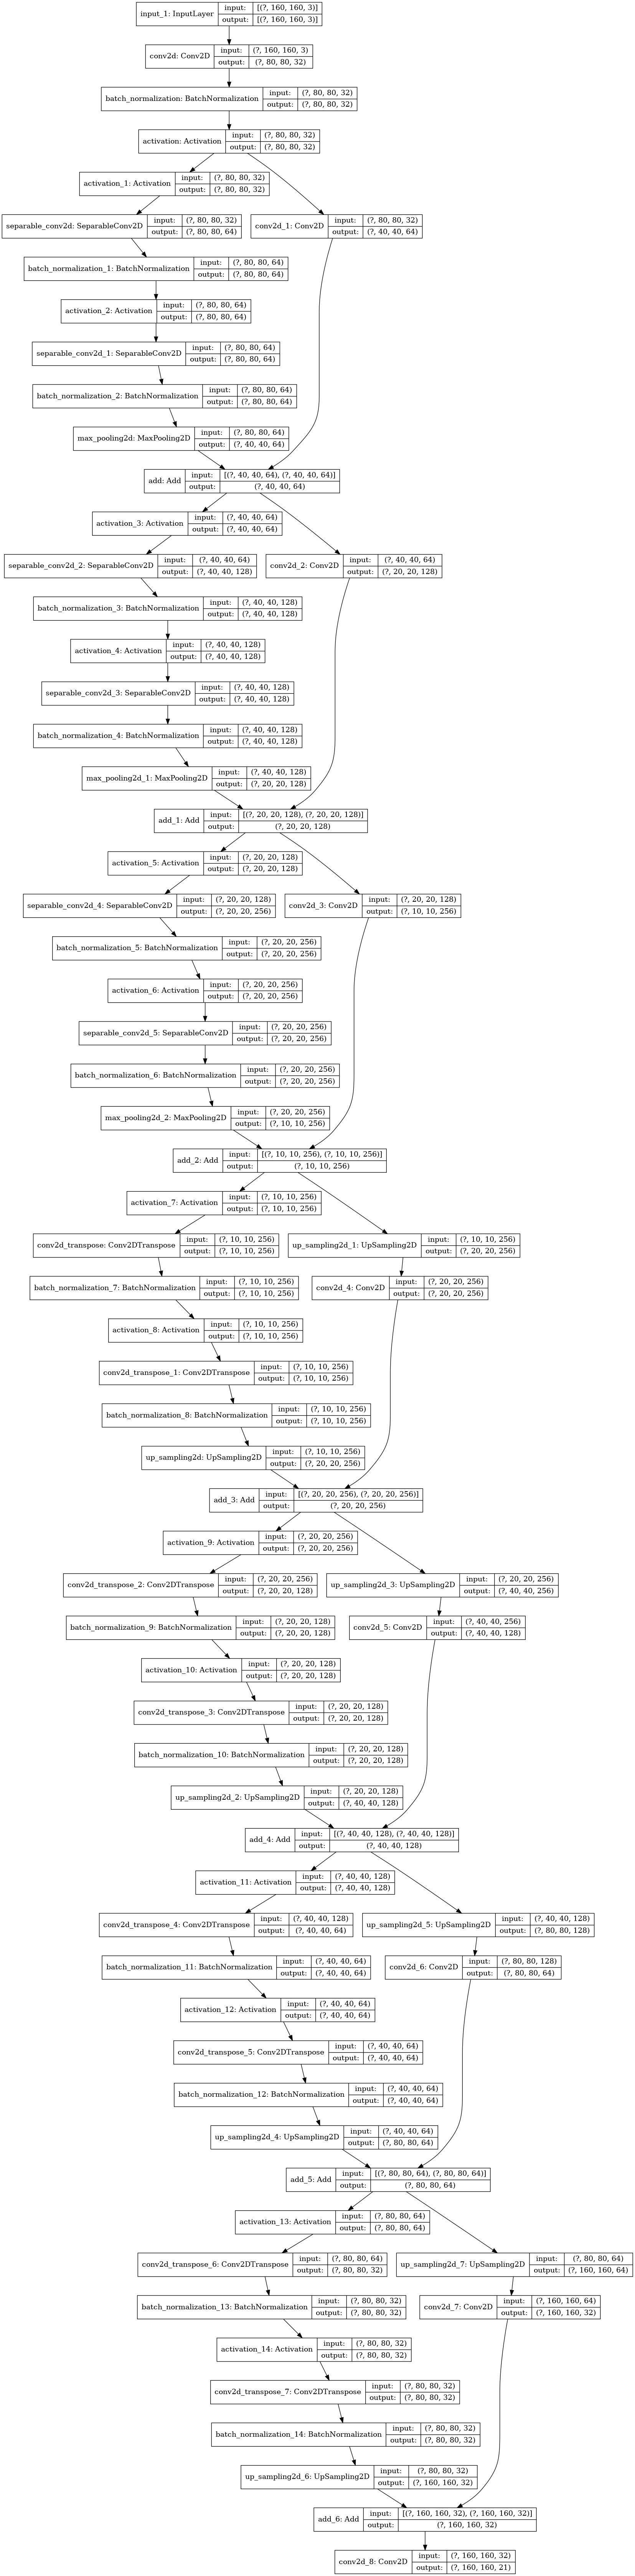

In [74]:
dig_path = 'model.png'

tf.keras.utils.plot_model(model, dig_path, show_shapes=True)
Image(dig_path)

**Training**

The CNN is trained for 30 epochs.

In [75]:
epochs = 30
train_steps = ceil(train_num_samples / batch_size)
val_steps = ceil(val_num_samples / batch_size)

!mkdir voc_pascal_2012_xception_unet
save_path = 'voc_pascal_2012_xception_unet/checkpoint'

The optimizer used for gradient based weight updation is Adam with pixel-wise crossentropy loss.

In [76]:
model.compile('adam', 'sparse_categorical_crossentropy')

In [77]:
history = model.fit(train_ds, epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_data=val_ds, validation_steps=val_steps)
model.save(save_path)

Epoch 1/30
46/46 [==============================] - 19s 420ms/step - loss: 1.7179 - val_loss: 1.5138
Epoch 2/30
46/46 [==============================] - 13s 282ms/step - loss: 0.7030 - val_loss: 1.0549
Epoch 3/30
46/46 [==============================] - 13s 283ms/step - loss: 0.6355 - val_loss: 1.1392
Epoch 4/30
46/46 [==============================] - 13s 285ms/step - loss: 0.6160 - val_loss: 1.1149
Epoch 5/30
46/46 [==============================] - 13s 290ms/step - loss: 0.6120 - val_loss: 1.1330
Epoch 6/30
46/46 [==============================] - 13s 292ms/step - loss: 0.5855 - val_loss: 1.1250
Epoch 7/30
46/46 [==============================] - 14s 296ms/step - loss: 0.5757 - val_loss: 1.0307
Epoch 8/30
46/46 [==============================] - 14s 299ms/step - loss: 0.5448 - val_loss: 1.1182
Epoch 9/30
46/46 [==============================] - 14s 304ms/step - loss: 0.5309 - val_loss: 1.1977
Epoch 10/30
46/46 [==============================] - 14s 304ms/step - loss: 0.5110 - val_lo

The model learning curve is visualised for training and validation set.

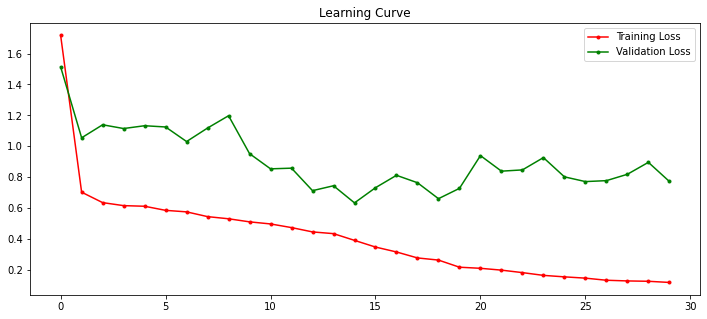

In [78]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], 'r.-')
plt.plot(history.history['val_loss'], 'g.-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Learning Curve')
plt.show()

**Visualize Predictions**

We visualize the predictions of the network for training and validation sets.

In [79]:
def get_single_batch(ds):
    for images, labels in ds:
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1).numpy()

        images = images.numpy()
        labels = labels.numpy()
        break
    return images, labels, preds

In [80]:
def show(image, label, pred):
    plt.figure(figsize=[10, 10])

    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    colorized = colormap.numpy()[label]
    plt.imshow(colorized.reshape(*image_size, 3))
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    colorized = colormap.numpy()[pred]
    plt.imshow(colorized.reshape(*image_size, 3))
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    gray = tf.image.rgb_to_grayscale(image).numpy()[..., 0]
    plt.imshow(gray, cmap='gray')
    plt.imshow(colorized.reshape(*image_size, 3), alpha=0.4)
    plt.title("Superimposed")
    plt.axis("off")

    plt.show()

Training dataset


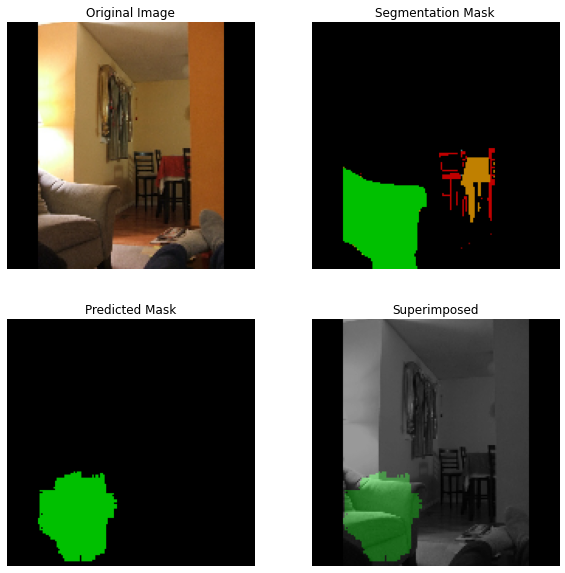

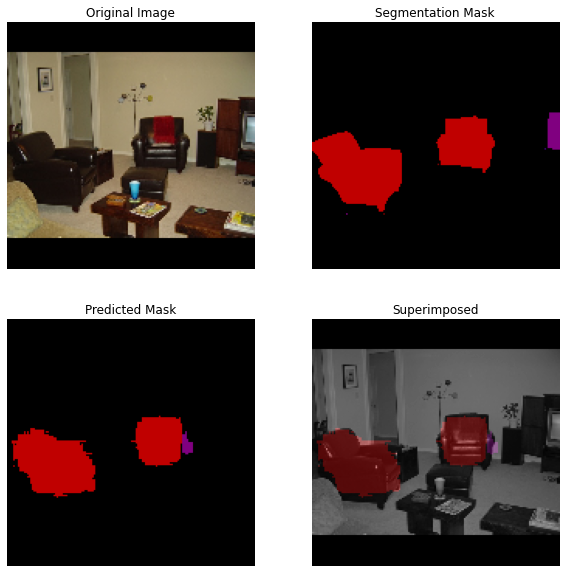

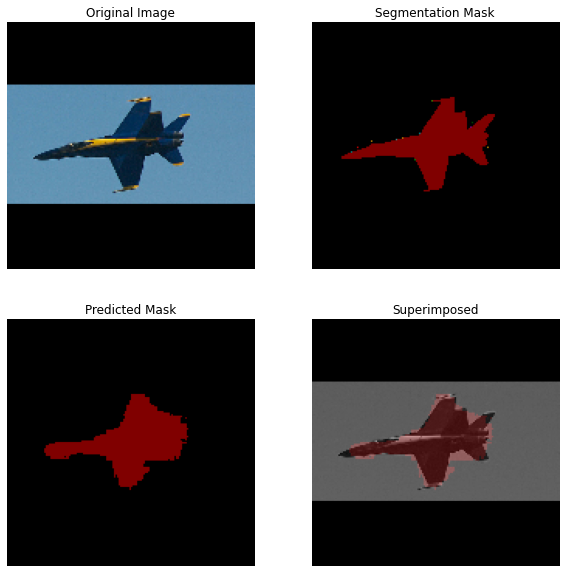

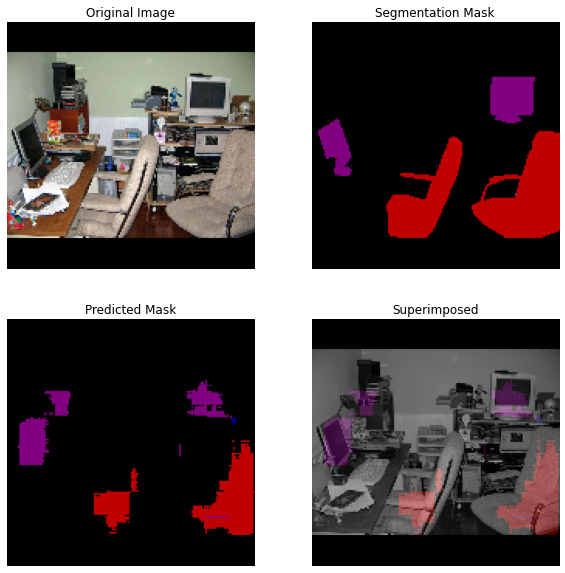

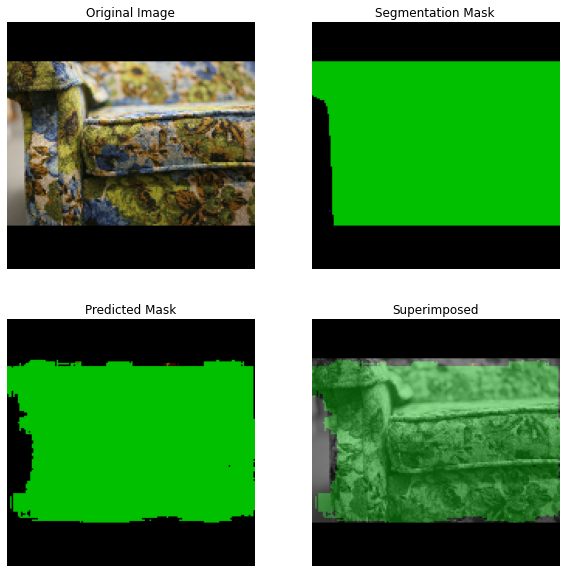

[None, None, None, None, None]

In [81]:
print("Training dataset")
images, labels, preds = get_single_batch(train_ds)
[show(images[idx], labels[idx], preds[idx]) for idx in range(5)]

Validation dataset


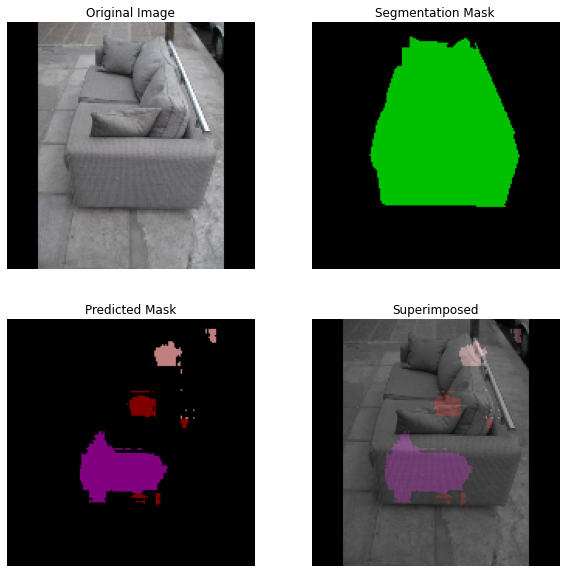

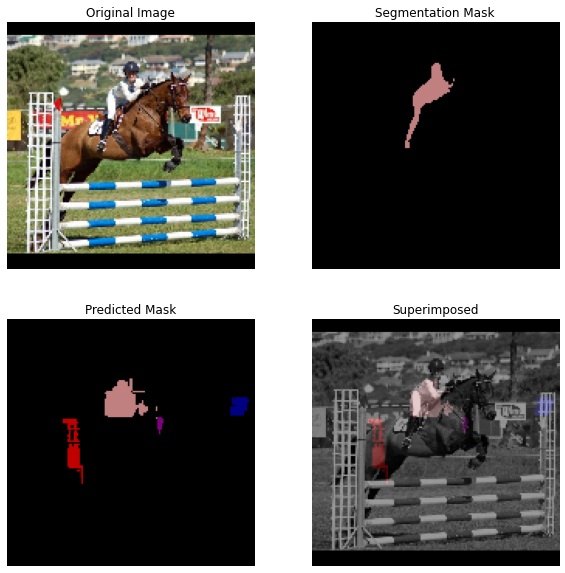

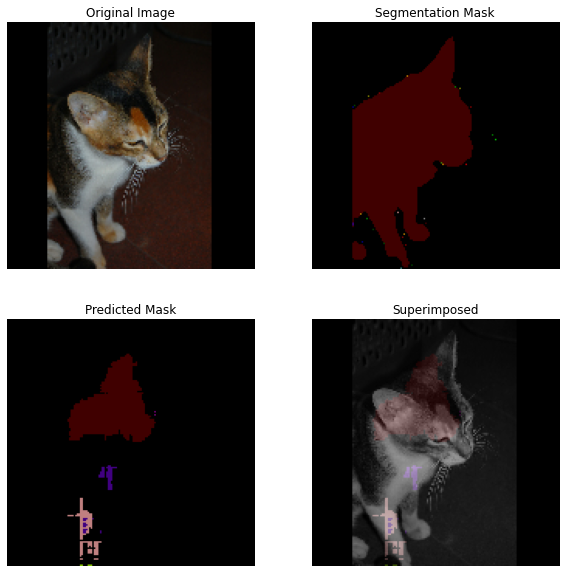

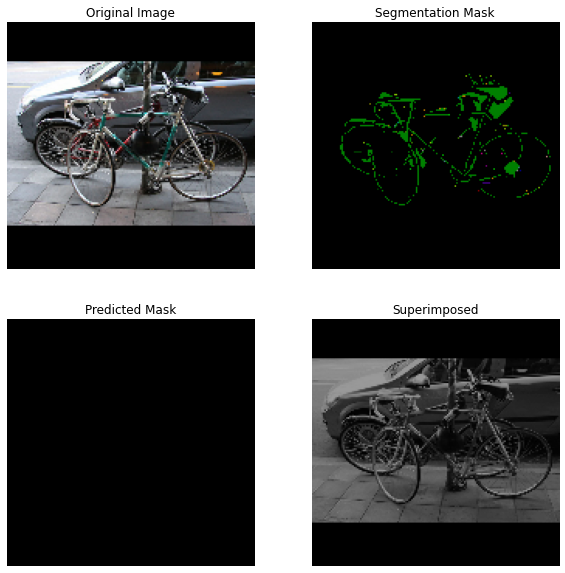

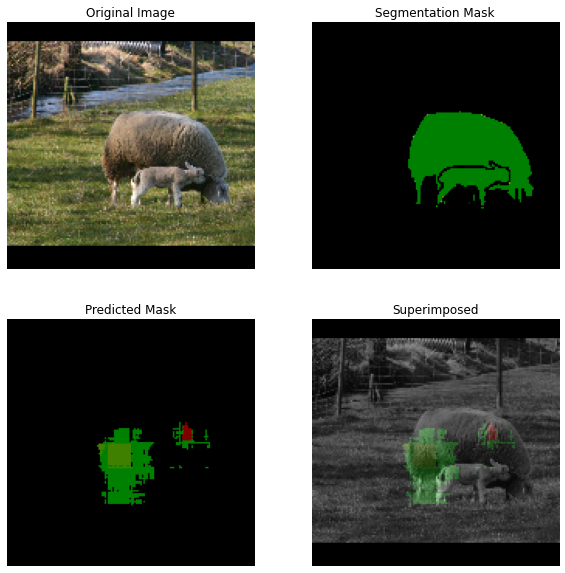

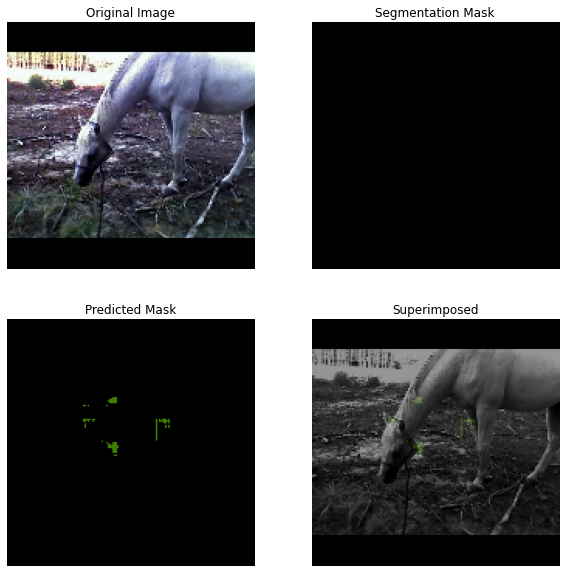

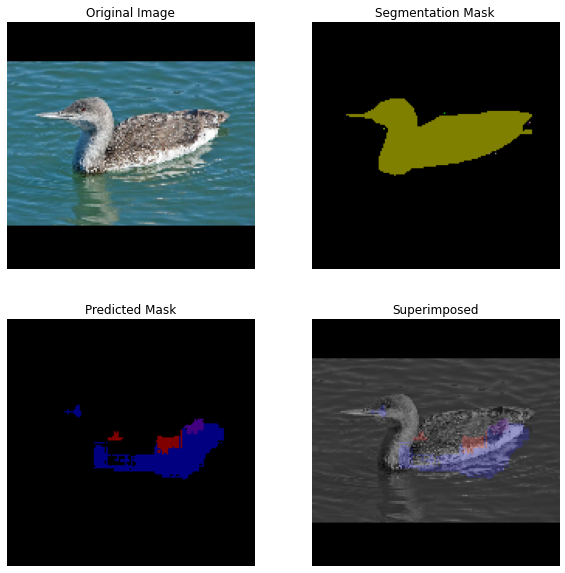

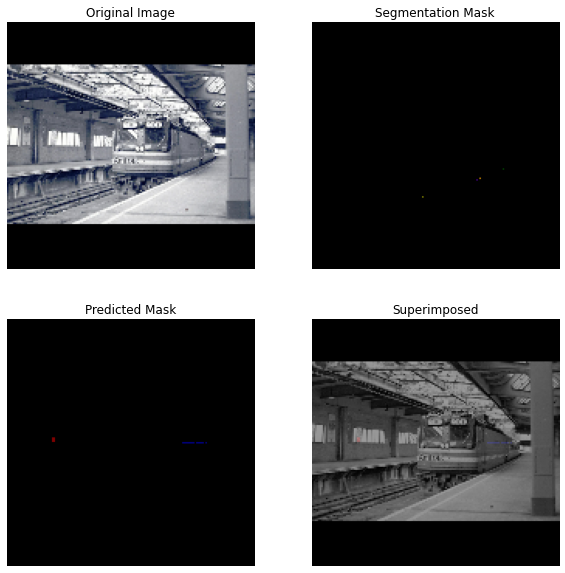

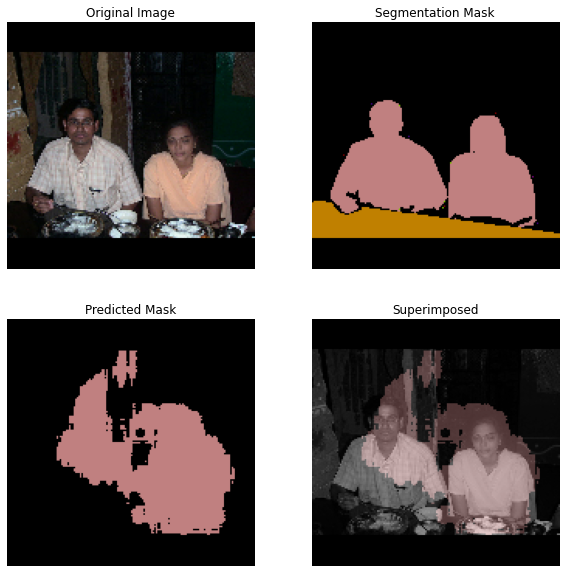

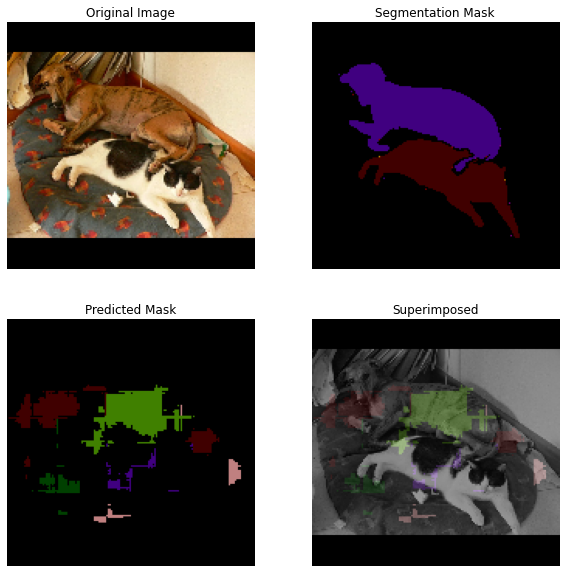

[None, None, None, None, None, None, None, None, None, None]

In [82]:
print("Validation dataset")
images, labels, preds = get_single_batch(val_ds)
[show(images[idx], labels[idx], preds[idx]) for idx in range(10)]

## Q6.
Build a neural network architecture from scratch in Python and perform the multi-class classification task on dataset of your choice.

Parameters to be considered while creating the neural network from scratch are specified as:
1. No. of hidden layers: 1 or more
2. No. of neurons in hidden layer: 100 or more
3. Non-linearity in the layer: ReLU
4. Use more than 1 neuron in the output layer. (Use a suitable threshold value)
5. Optimisation algorithm: Stochastic Gradient Descent (SGD) 
6. Loss function: categorical cross entropy loss 

**Note :-** Do not use any external python library.

Do a random initialization of the weights. And, use the learning rate value as 0.1 while conducting the experiment.

<hr>

We import a few functions from `scikit-learn` package for:
- loading the handwritten digits dataset
- splitting the dataset into 70:30 train:test ratio 

The test set will be used to evaluate classifier.

In [83]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from math import ceil

We define a function to calculate multi-class accuracy given target values and the logits predicted by last layer of a neural network.

In [84]:
@typechecked
def multi_class_accuracy(y: np.ndarray, logits: np.ndarray) -> np.float64:
    sparse_y = np.argmax(y, axis=1)
    y_predict = np.argmax(logits, axis=1)
    
    checks = (sparse_y == y_predict).astype(np.float32)
    acc = np.mean(checks)
    return acc

We test the implementation by passing sample values.

In [85]:
y = np.array([[1, 0, 1],
              [0, 1, 0],
              [0, 0, 1],
              [1, 0, 0]])
logits =  np.array([[0.7, 0.1, 0.2],
                    [0.6, 0.4, 0.0],
                    [0.3, 0.1, 0.6],
                    [0.2, 0.2, 0.6]])

multi_class_accuracy(y, logits)

0.5

The handwritten digits dataset is loaded.

In [86]:
digits = load_digits()
X = digits.data
y = digits.target
X.shape

(1797, 64)

In [87]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

The class labels from the dataset are being one hot encoded in order to make it suitable for training with a multi-class classifier.

In [88]:
n_classes = len(digits.target_names)
eye = np.eye(n_classes)
y = eye[y]

Stochastic gradient descent algotithm is a popular algorithm that is generally used in conjunction with back propagation of neural networks and is well suited to smaller datasets. As opposed to batch gradient descent (simply called as gradient descent), in case of SGD the gradients are computed on a small min-batch of samples or single sample instead of complete dataset. The SGD algorithm helps neural networks to scale well to larger training loads as well have inspired the recent evolutions in the field of deep learning in general.

For this experiment we use SGD with a mini-batch size of 32.

A good practice is to normalize the input data in a range of (0, 1) such that alpha values in less order of magnitudes can benefit from same. The data has been normalized in this case by applying $ X := \frac {X}  {X_{max}} $.

In [89]:
def train_classifier(X, y, alpha, epochs):
    # split the data into 70:30 train:test
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=7)
    
    # normalize data to a range [0, 1] for better training!
    X_max = X_train.max()
    X_train = X_train / X_max
    X_test = X_test / X_max
    
    sgd_batch_size = 32
    
    # a neural network with 5 hidden layers is constructed
    digit_classifier = NN([
        Layer(X.shape[-1], 32, relu, relu_grad),
        Layer(32, 64, relu, relu_grad),
        Layer(64, 128, relu, relu_grad),
        Layer(128, n_classes, sigmoid, sigmoid_grad),
    ], alpha=alpha)
    print(digit_classifier)
    
    # the classifier is trained for 100 epochs 
    # using mini-batches of size 32
    # iterated over complet train set
    # classifier is evaluated on test set
    for e in range(epochs):
        n_batches = ceil(X_train.shape[0] / sgd_batch_size)
        for j in range(n_batches):
            X_batch = X_train[j * sgd_batch_size : (j + 1) * sgd_batch_size]
            y_batch = y_train[j * sgd_batch_size : (j + 1) * sgd_batch_size]

            digit_classifier.train(X_batch, y_batch, 1, False)

        y_train_predict = digit_classifier(X_train)
        y_test_predict = digit_classifier(X_test)

        train_loss = crossentropy(y_train, y_train_predict)
        test_loss = crossentropy(y_test, y_test_predict)
        print(f"Epoch {e + 1} - Train loss: {train_loss}, Test loss: {test_loss}", end='\n')

        train_acc = multi_class_accuracy(y_train, y_train_predict)
        test_acc = multi_class_accuracy(y_test, y_test_predict)
        print(f"Epoch {e + 1} - Train accuracy: {train_acc}, Test accuracy: {test_acc}") 

In [90]:
train_classifier(X, y, alpha=0.01, epochs=100)

Layer 0: (64, 32)
Layer 1: (32, 64)
Layer 2: (64, 128)
Layer 3: (128, 10)

Epoch 1 - Train loss: 5.933929319122344, Test loss: 5.9286439779705775
Epoch 1 - Train accuracy: 0.14001591503620148, Test accuracy: 0.12222222238779068
Epoch 2 - Train loss: 4.873956973251938, Test loss: 4.869134649795253
Epoch 2 - Train accuracy: 0.128082737326622, Test accuracy: 0.11481481790542603
Epoch 3 - Train loss: 3.9553975754589326, Test loss: 3.953306316285663
Epoch 3 - Train accuracy: 0.12330946326255798, Test accuracy: 0.1111111119389534
Epoch 4 - Train loss: 3.4952297316630667, Test loss: 3.496487811597468
Epoch 4 - Train accuracy: 0.1360381841659546, Test accuracy: 0.12962962687015533
Epoch 5 - Train loss: 3.3218748076631823, Test loss: 3.3260091160554115
Epoch 5 - Train accuracy: 0.14717581868171692, Test accuracy: 0.14814814925193787
Epoch 6 - Train loss: 3.2544403357162524, Test loss: 3.2606414135189374
Epoch 6 - Train accuracy: 0.1654733419418335, Test accuracy: 0.17592592537403107
Epoch 7 - T

In [91]:
train_classifier(X, y, alpha=0.1, epochs=100)

Layer 0: (64, 32)
Layer 1: (32, 64)
Layer 2: (64, 128)
Layer 3: (128, 10)

Epoch 1 - Train loss: 3.2214616505275515, Test loss: 3.22997178745948
Epoch 1 - Train accuracy: 0.16070008277893066, Test accuracy: 0.15925925970077515
Epoch 2 - Train loss: 3.1853624578465265, Test loss: 3.2026807727794524
Epoch 2 - Train accuracy: 0.25059667229652405, Test accuracy: 0.22592592239379883
Epoch 3 - Train loss: 3.150585772755247, Test loss: 3.172558950405268
Epoch 3 - Train accuracy: 0.31105807423591614, Test accuracy: 0.28148147463798523
Epoch 4 - Train loss: 3.1105760769118502, Test loss: 3.1369031341574356
Epoch 4 - Train accuracy: 0.3548130393028259, Test accuracy: 0.34259259700775146
Epoch 5 - Train loss: 3.059074882936592, Test loss: 3.0904331021218217
Epoch 5 - Train accuracy: 0.39459028840065, Test accuracy: 0.3611111044883728
Epoch 6 - Train loss: 2.989449399452896, Test loss: 3.027597225183898
Epoch 6 - Train accuracy: 0.40970563888549805, Test accuracy: 0.38148146867752075
Epoch 7 - Tra

The classifier was trained using alpha value as 0.1 and 0.01. It was noticed that the network performs slightly better when using learning rate 0.1 producing lower loss and little better accuracy when trained on 100 epochs.

# References

1. CSE3810: Artificial Neural Networks - https://sites.google.com/site/artificialneuralnetworksann/lecture-notes
2. Machine Learning | Coursera - https://www.coursera.org/learn/machine-learning
3. Image segmentation with a U-Net-like architecture | Keras.io - https://keras.io/examples/vision/oxford_pets_image_segmentation/
4. CS229: Machine Learning | Stanford University - http://cs229.stanford.edu/
5. CS231n: Convolutional Neural Networks for Visual Recognition | Stanford University - http://cs231n.stanford.edu/
6. NumPy - https://numpy.org/
7. TensorFlow - https://www.tensorflow.org/
8. scikit-learn: machine learning in Python - https://scikit-learn.org/
9. Matplotlib: Python plotting - https://matplotlib.org/
10. Typeguard - https://typeguard.readthedocs.io/en/latest/
11. Hands-on Machine Learning with Scikit-Learn and TensorFlow | ageron/handson-ml - https://github.com/ageron/handson-ml